# Weather Exploration Notebook

In [1]:
import pandas as pd
import numpy as np

import os.path
import requests
import io

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import wrangle
import model
import preprocessing

In [2]:
weather_data = pd.read_csv("US_WeatherEvents_2016-2019.csv")

In [3]:
weather_data[weather_data.State == "NC"].City.unique()

array(['Davis', 'Sanford', 'Goldsboro', 'Salisbury', 'Greensboro',
       'Southport', 'Louisburg', 'Oxford', 'Stoneville', 'Elm City',
       'Smithfield', 'Statesville', 'Franklin', 'Concord', 'Monroe',
       'Richlands', 'Rockingham', 'Whiteville', 'Pope Army Airfield',
       'Washington', 'Erwin', 'Pikeville', 'Tarboro', 'Wilmington',
       'New London', 'Morrisville', 'Mount Airy', 'Jefferson',
       'Engelhard', 'Frisco', 'Andrews', 'Elizabeth City', 'New Bern',
       'Winston Salem', 'Lexington', 'Elizabethtown', 'Iron Station',
       'Rutherfordton', 'Aulander', 'Asheboro', 'Timberlake',
       'Burlington', 'Maxton', 'Wadesboro', 'North Wilkesboro', 'Hoffman',
       'Jacksonville', 'Carthage', 'Edenton', 'Kinston', 'Lumberton',
       'Clinton', 'Fayetteville', 'Manteo', 'Newport', 'Halifax',
       'Kenansville', 'Beaufort', 'Havelock', 'Cleveland', 'Gastonia',
       'Morganton', 'Greenville', 'Maple', 'New River', 'Fletcher',
       'Township 2 Berryhill', 'Kill Devi

In [4]:
weather_data[weather_data.City == "Dallas"]

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
788917,W-789030,Rain,Light,2016-01-06 15:53:00,2016-01-06 16:53:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788918,W-789031,Rain,Light,2016-01-07 01:39:00,2016-01-07 02:00:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788919,W-789032,Rain,Light,2016-01-07 02:18:00,2016-01-07 02:41:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788920,W-789033,Rain,Heavy,2016-01-07 02:41:00,2016-01-07 03:06:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788921,W-789034,Rain,Moderate,2016-01-07 03:06:00,2016-01-07 04:26:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805626,W-3806127,Rain,Light,2019-12-29 18:15:00,2019-12-29 18:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805627,W-3806128,Rain,Light,2019-12-29 20:35:00,2019-12-29 20:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805628,W-3806129,Rain,Light,2019-12-29 22:15:00,2019-12-29 22:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805629,W-3806130,Rain,Light,2019-12-30 01:55:00,2019-12-30 02:35:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0


In [5]:
# we only want data for 2018

In [6]:
# we only wand data for the following cities

top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

In [7]:
airport_codes = pd.read_csv("airport_codes.csv")

In [8]:
airport_codes = airport_codes[airport_codes.Country == "United States"]

In [9]:
airport_codes.head()

,Unnamed: 0,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,3212,Barter Island LRRS Airport,Barter Island,United States,BTI,PABA,70.134003,-143.582001
1,3213,Wainwright Air Station,Fort Wainwright,United States,\N,PAWT,70.613403,-159.860001
2,3214,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,PALU,68.875099,-166.110001
3,3215,Point Lay LRRS Airport,Point Lay,United States,PIZ,PPIZ,69.732903,-163.005005
4,3216,Hilo International Airport,Hilo,United States,ITO,PHTO,19.721399,-155.048004


In [10]:
# airport_codes.to_csv("airport_codes.csv")

In [11]:
weather_data = weather_data.merge(airport_codes, how="left", left_on="AirportCode", right_on="ICAO")

In [12]:
top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

for i in top_airports:
    weather_data.loc[weather_data['IATA'] == i, 'is_top'] = True 
    
weather_data.is_top = weather_data.is_top.fillna(False)

In [13]:
weather_data = weather_data[weather_data.is_top]

In [14]:
weather_data["StartTime(UTC)"] = pd.to_datetime(weather_data["StartTime(UTC)"])

In [15]:
weather_data = weather_data.set_index("StartTime(UTC)")

In [16]:
weather_data = weather_data["2018"]

In [17]:
weather_data.sort_values("City_y")

,EventId,Type,Severity,EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City_x,County,...,ZipCode,Unnamed: 0,Name,City_y,Country,IATA,ICAO,Latitude,Longitude,is_top
StartTime(UTC),,,,,,,,,,,,,,,,,,,,,
2018-12-01 17:58:00,W-3204675,Rain,Light,2018-12-01 18:13:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,...,30320.0,3482.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-09 20:52:00,W-3204531,Rain,Light,2018-09-09 21:18:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,...,30320.0,3482.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-10 19:05:00,W-3204532,Rain,Light,2018-09-10 19:14:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,...,30320.0,3482.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-11 20:12:00,W-3204533,Rain,Light,2018-09-11 20:52:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,...,30320.0,3482.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-11 20:57:00,W-3204534,Rain,Light,2018-09-11 21:52:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,...,30320.0,3482.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-24 14:12:00,W-3376399,Cold,Severe,2018-06-24 14:46:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,...,98148.0,3377.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True
2018-06-24 15:53:00,W-3376400,Fog,Moderate,2018-06-24 17:22:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,...,98148.0,3377.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True
2018-06-28 21:53:00,W-3376401,Rain,Light,2018-06-28 22:53:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,...,98148.0,3377.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True


---

In [18]:
weather = pd.DataFrame()
unique_cities = weather_data.City_y.unique()

for city in unique_cities:
    city_data = weather_data[weather_data.City_y == city]
    r = pd.date_range(start=city_data.index.min(), end=city_data.index.max(), freq="H")
    city_data = city_data.reindex(r, copy=True)
    city_data["EndTime(UTC)"] = city_data["EndTime(UTC)"].fillna(method="ffill")
    for i in range(city_data["EndTime(UTC)"].unique().shape[0]):
        date = city_data["EndTime(UTC)"].unique()[i]
        mask = (city_data["EndTime(UTC)"] == date) & (city_data.index >= date)
        city_data["Type"] = city_data["Type"].mask(mask, city_data["Type"].fillna("Clear"))
    mask = city_data.Type != "Clear"
    city_data = city_data.mask(mask, city_data.fillna(method="ffill"))
    city_data = city_data.fillna(method="ffill")  
    
    weather = pd.concat([weather, city_data])

In [19]:
features_to_keep = ["Type", "Severity", "TimeZone", "IATA", "City_y", "State"]

weather = weather[features_to_keep]

weather = weather.sort_values(["City_y", "State"])

weather.rename(columns={"City_y":"city"}, inplace=True)

In [20]:
weather.head()

,Type,Severity,TimeZone,IATA,city,State
2018-01-01 14:52:00,Snow,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 15:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 16:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 17:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 18:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA


In [21]:
# We will now normalize the data by changing all time stamps to :30 minutes, to makes it easier to merge
# with our flights df 

weather.index = weather.index.map(lambda t: t.replace(minute=30))

In [22]:
time_zones = weather.TimeZone.unique()
weather_df = pd.DataFrame()
for zone in time_zones:
    mask = weather.TimeZone == zone
    time_zone_df = weather[mask].tz_localize('utc').tz_convert(zone).tz_localize(None)
    weather_df = pd.concat([weather_df, time_zone_df])
    

In [23]:
weather_df["unique_id"] = weather_df.index.astype(str) + "_" + weather_df.IATA

In [24]:
weather_df = weather_df.reset_index().rename(columns={"index": "date"})

In [25]:
weather_df

,date,Type,Severity,TimeZone,IATA,city,State,unique_id
0,2018-01-01 09:30:00,Snow,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 09:30:00_ATL
1,2018-01-01 10:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 10:30:00_ATL
2,2018-01-01 11:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 11:30:00_ATL
3,2018-01-01 12:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 12:30:00_ATL
4,2018-01-01 13:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 13:30:00_ATL
...,...,...,...,...,...,...,...,...
129666,2018-12-31 07:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 07:30:00_SEA
129667,2018-12-31 08:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 08:30:00_SEA
129668,2018-12-31 09:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 09:30:00_SEA
129669,2018-12-31 10:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 10:30:00_SEA


-----

In [26]:
df = wrangle.prep_flight_data()

In [27]:
df["crs_dep_time"] = df['crs_dep_time'].astype(str).apply(lambda x: x.zfill(4))

In [28]:
df["fl_datetime"] = df.fl_date.astype(str) + " " + df.crs_dep_time.astype(str)

In [29]:
df.fl_datetime = pd.to_datetime(df.fl_datetime, format="%Y-%m-%d %H%M")

In [30]:
df = df.set_index("fl_datetime")

In [31]:
df.index = df.index.map(lambda t: t.replace(minute=30))

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2965760 entries, 2018-01-01 15:30:00 to 2018-12-31 13:30:00
Data columns (total 18 columns):
fl_date                object
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           object
dep_time               float64
dep_delay              float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
dtypes: float64(10), int64(2), object(6)
memory usage: 429.9+ MB


In [33]:
features_to_keep = ["fl_date", "op_carrier", "op_carrier_fl_num", "crs_dep_time", "origin", "dest", "dep_delay", "arr_delay", "weather_delay", "Airline"]

In [34]:
df = df[features_to_keep]

In [35]:
df = df.reset_index()

In [36]:
df

,fl_datetime,fl_date,op_carrier,op_carrier_fl_num,crs_dep_time,origin,dest,dep_delay,arr_delay,weather_delay,Airline
0,2018-01-01 15:30:00,2018-01-01,UA,2429,1517,EWR,DEN,-5.0,-23.0,0.0,United Air Lines Inc.
1,2018-01-01 11:30:00,2018-01-01,UA,2427,1115,LAS,SFO,-8.0,-24.0,0.0,United Air Lines Inc.
2,2018-01-01 06:30:00,2018-01-01,UA,2424,0630,ORD,ALB,20.0,14.0,0.0,United Air Lines Inc.
3,2018-01-01 22:30:00,2018-01-01,UA,2422,2241,ORD,OMA,3.0,-11.0,0.0,United Air Lines Inc.
4,2018-01-01 07:30:00,2018-01-01,UA,2421,0750,IAH,LAS,-3.0,-16.0,0.0,United Air Lines Inc.
...,...,...,...,...,...,...,...,...,...,...,...
2965755,2018-12-31 19:30:00,2018-12-31,AA,1814,1955,DFW,PHL,31.0,9.0,0.0,American Airlines Inc.
2965756,2018-12-31 13:30:00,2018-12-31,AA,1815,1321,CLT,DCA,-1.0,-23.0,0.0,American Airlines Inc.
2965757,2018-12-31 17:30:00,2018-12-31,AA,1816,1751,CLT,DFW,6.0,1.0,0.0,American Airlines Inc.
2965758,2018-12-31 20:30:00,2018-12-31,AA,1817,2015,CLT,MEM,-5.0,11.0,0.0,American Airlines Inc.


In [37]:
df["unique_id"] = df.fl_datetime.astype(str) + "_" + df.origin

In [38]:
df.head()

,fl_datetime,fl_date,op_carrier,op_carrier_fl_num,crs_dep_time,origin,dest,dep_delay,arr_delay,weather_delay,Airline,unique_id
0,2018-01-01 15:30:00,2018-01-01,UA,2429,1517,EWR,DEN,-5.0,-23.0,0.0,United Air Lines Inc.,2018-01-01 15:30:00_EWR
1,2018-01-01 11:30:00,2018-01-01,UA,2427,1115,LAS,SFO,-8.0,-24.0,0.0,United Air Lines Inc.,2018-01-01 11:30:00_LAS
2,2018-01-01 06:30:00,2018-01-01,UA,2424,0630,ORD,ALB,20.0,14.0,0.0,United Air Lines Inc.,2018-01-01 06:30:00_ORD
3,2018-01-01 22:30:00,2018-01-01,UA,2422,2241,ORD,OMA,3.0,-11.0,0.0,United Air Lines Inc.,2018-01-01 22:30:00_ORD
4,2018-01-01 07:30:00,2018-01-01,UA,2421,0750,IAH,LAS,-3.0,-16.0,0.0,United Air Lines Inc.,2018-01-01 07:30:00_IAH


In [39]:
df = df.sort_values(["origin", "fl_datetime", "op_carrier"])

---

In [40]:
test = df.merge(weather_df[["Type", "Severity", "unique_id"]], how="left", right_on="unique_id", left_on="unique_id")

In [41]:
weather_df[weather_df.IATA == "CLT"]

,date,Type,Severity,TimeZone,IATA,city,State,unique_id
8738,2018-01-08 15:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 15:30:00_CLT
8739,2018-01-08 16:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 16:30:00_CLT
8740,2018-01-08 17:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 17:30:00_CLT
8741,2018-01-08 18:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 18:30:00_CLT
8742,2018-01-08 19:30:00,Clear,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 19:30:00_CLT
...,...,...,...,...,...,...,...,...
17304,2018-12-31 13:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 13:30:00_CLT
17305,2018-12-31 14:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 14:30:00_CLT
17306,2018-12-31 15:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 15:30:00_CLT
17307,2018-12-31 16:30:00,Clear,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 16:30:00_CLT


In [42]:
test.Type = test.Type.fillna("Clear")

In [43]:
test.Severity = test.Severity.fillna("Light")

In [44]:
test

,fl_datetime,fl_date,op_carrier,op_carrier_fl_num,crs_dep_time,origin,dest,dep_delay,arr_delay,weather_delay,Airline,unique_id,Type,Severity
0,2018-01-01 05:30:00,2018-01-01,WN,1981,0530,ATL,DEN,-1.0,-7.0,0.0,Southwest Airlines Co.,2018-01-01 05:30:00_ATL,Clear,Light
1,2018-01-01 06:30:00,2018-01-01,AA,1731,0600,ATL,PHL,-3.0,-27.0,0.0,American Airlines Inc.,2018-01-01 06:30:00_ATL,Clear,Light
2,2018-01-01 06:30:00,2018-01-01,AA,2326,0629,ATL,ORD,71.0,52.0,0.0,American Airlines Inc.,2018-01-01 06:30:00_ATL,Clear,Light
3,2018-01-01 06:30:00,2018-01-01,AA,958,0600,ATL,MIA,-4.0,-12.0,0.0,American Airlines Inc.,2018-01-01 06:30:00_ATL,Clear,Light
4,2018-01-01 06:30:00,2018-01-01,AA,2515,0630,ATL,LAX,-7.0,-11.0,0.0,American Airlines Inc.,2018-01-01 06:30:00_ATL,Clear,Light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965769,2018-12-31 23:30:00,2018-12-31,UA,1796,2300,SFO,EWR,38.0,20.0,0.0,United Air Lines Inc.,2018-12-31 23:30:00_SFO,Clear,Light
2965770,2018-12-31 23:30:00,2018-12-31,UA,1204,2305,SFO,IAH,-2.0,-1.0,0.0,United Air Lines Inc.,2018-12-31 23:30:00_SFO,Clear,Light
2965771,2018-12-31 23:30:00,2018-12-31,UA,995,2345,SFO,ORD,33.0,24.0,0.0,United Air Lines Inc.,2018-12-31 23:30:00_SFO,Clear,Light
2965772,2018-12-31 23:30:00,2018-12-31,UA,697,2330,SFO,IAD,-5.0,-14.0,0.0,United Air Lines Inc.,2018-12-31 23:30:00_SFO,Clear,Light


---

# Exploration

In [45]:
plt.figure(figsize=(15,5))
sns.barplot(data=test,x="Type", y="arr_delay", ci=False)
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")

KeyboardInterrupt: 

<Figure size 1080x360 with 0 Axes>

Interesting - it seems that storms lead to the total highest minutes in delays, followed by snow. Extremely cold temperatures seems to have the lowerst number of delays, as well as clear skys.

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(data=test,x="Type", y="arr_delay")
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")

There are clearly some really high outliers - but overall, Storm stills seems to have the biggest average, closely followed perhaps by precipitation. 

On a positive note, we have evidence that weather isn't the only reason a plane is delayed, as we still see delays when the sky's are clear, however, they are clearly the minority, so we can hopefuly expect the model will greatly improve with this tipe of information.

In [ ]:
# plt.figure(figsize=(15,5))
# sns.lineplot(data=test, x="fl_datetime", y="arr_delay", hue="Type", ci=False)
# plt.title("How does weather over time have an impact on delays?")
# plt.ylabel("Minutes delayed")
# plt.xlabel("Flight Date")

In [ ]:
# does the weather severity play a role?

plt.figure(figsize=(15,5))
sns.barplot(data=test, y="arr_delay", x="Severity")
plt.title("Does weather severity play a role in delays?")

In [ ]:
severity = test.Severity.unique()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

for count, i in enumerate(severity):
     
    data = test[test.Severity == i]
    plt.subplot(3, 3, count + 1)
    sns.barplot(data=data, x="Type", y="arr_delay", ci=False)
    plt.title(f"{i}")
    fig.tight_layout()
    
plt.show()
        
    


Interestingly, we see that actually `heavy` precipiation seems to cause the most delays, with `Heavy Snow` causing the greatest delays.

In [ ]:
severity = test.Severity.unique()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

for count, i in enumerate(severity):
     
    data = test[test.Severity == i]
    plt.subplot(3, 3, count + 1)
    sns.boxplot(data=data, x="Type", y="arr_delay")
    plt.title(f"{i}")
    fig.tight_layout()
    
plt.show()

# Preprocessing

Features for modeling

* Avg delay per weather type
* avg airport delay
* avg carrier delay
* avg day of week delay
* avg month delay
* avg delay for dept time

In [ ]:
test = df.merge(weather_df[["Type", "Severity", "unique_id"]], how="left", right_on="unique_id", left_on="unique_id")

test.Type = test.Type.fillna("Clear")

test.Severity = test.Severity.fillna("Light")

In [ ]:
# test = test[test.origin == "CLT"]

In [ ]:
features_for_modeling = ["carrier_avg_delay", "airport_avg_delay", "observation", "crd_dep_time", "avg_type_severity", "is_delay", "month"]
target_variable = "is_delay"

In [ ]:
test.fl_date = pd.to_datetime(test.fl_date)
test["day_of_week"] = test.fl_date.dt.dayofweek
test["month"] = test.fl_date.dt.month

In [ ]:
test["avg_month_delay"] = test.groupby("month").arr_delay.transform("mean")

In [ ]:
test["avg_day_of_week_delay"] = test.groupby("day_of_week").arr_delay.transform("mean")

In [ ]:
test["airport_avg_delay"] = test.groupby("origin").arr_delay.transform("mean")

In [ ]:
test["dest_airport_avg_delay"] = test.groupby("dest").arr_delay.transform("mean")

In [ ]:
test["carrier_avg_delay"] = test.groupby("op_carrier").arr_delay.transform("mean")

In [ ]:
test["observation"] = test.fl_date.astype(str) + "_" + test.op_carrier + "_" + test.op_carrier_fl_num.astype(str)

In [ ]:
test

In [ ]:
# test["crs_dep_time"] = test['crs_dep_time'].astype(str).apply(lambda x: x.zfill(4))
# test["crs_dep_time"] = pd.to_datetime(test.crs_dep_time, format= "%H%M")
test["dep_time_mean_delay"] = test.groupby("crs_dep_time").arr_delay.transform("mean")

In [ ]:
# weather feature

test["avg_weather_delay"] = test.groupby("Type").arr_delay.transform("mean")

In [ ]:
test["type_severity"] = test.Type + "_" + test.Severity
test["avg_type_severity"] = test.groupby("type_severity").arr_delay.transform("mean")

In [ ]:
test.head()

In [ ]:
# add our target variable

test['is_delay'] = test['arr_delay'].apply(lambda x: True if x > 0 else False)

In [ ]:
test_modeling = test[features_for_modeling]
test_modeling = test_modeling.set_index("observation")

In [ ]:
train, validate, test = preprocessing.split_data(test_modeling)

In [ ]:
train, train_2 = train_test_split(train, random_state=123, train_size=.6)

In [ ]:
X_train = train.drop(columns=target_variable)
y_train = train[target_variable]
X_validate = validate.drop(columns=target_variable)
y_validate = validate[target_variable]
X_test = test.drop(columns=target_variable)
y_test = test[target_variable]

In [ ]:
scaler, train_scaled, validate_scaled, test_scaled = preprocessing.min_max_scaler(X_train, X_validate, X_test)

In [ ]:
train_scaled.shape

---

# Modeling

In [2]:
features_for_modeling = ["carrier_avg_delay", "airport_avg_delay", "observation", "crs_dep_time", "avg_type_severity", "is_delay", "month"]
target_variable = "is_delay"

In [3]:
train_scaled, y_train, validate_scaled, y_validate, test_scaled, y_test = preprocessing.weather_modeling_prep(modeling=True, features_for_modeling=features_for_modeling, target_variable=target_variable)

In [5]:
df = preprocessing.weather_modeling_prep()

In [5]:
# predictions = pd.DataFrame({"actual": y_train, "baseline": False})

ValueError: If using all scalar values, you must pass an index

## Random Forest

In [6]:
# model.run_rf_loop(train_scaled, validate_scaled, y_validate, y_train, 8)

In [8]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 3)
# predictions["random_forest"] = y_pred

In [10]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

AttributeError: 'DataFrame' object has no attribute 'accuracy'

In [11]:
rf.score(validate_scaled, y_validate)

0.6329306955975996

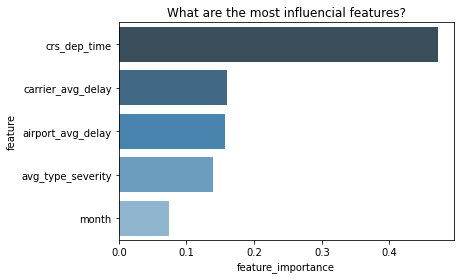

In [12]:
model.rf_feature_importance(rf, train_scaled)

# KNN

In [ ]:
# model.run_knn_loop(train_scaled, validate_scaled, y_validate, y_train, 10)

In [13]:
knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')

In [14]:
knn.fit(train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [15]:
y_pred = knn.predict(train_scaled)
# predictions["knn"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

In [16]:
knn.score(validate_scaled, y_validate)

0.6352253170839605

## Gradient Boosting Classifier

In [ ]:
def run_gb(X_train, y_train):
    gb = GradientBoostingClassifier(random_state = 123, n_estimators=300, learning_rate=0.003, max_depth=5).fit(X_train, y_train)
    y_pred = gb.predict(X_train)
    return gb, y_pred

In [ ]:
gb, y_pred = run_gb(train_scaled, y_train)
predictions["gradient_boosting"] = y_pred

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_train)

print(accuracy_score)
print(matrix)

report

In [ ]:
gb.score(validate_scaled, y_validate)

In [ ]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

In [ ]:
# How do the different models compare on recall?
print("Precision Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["precision"]:.2f}')

In [ ]:
grid, df_result, best_model = model.run_knn_cv(validate_scaled, y_validate)

# Evaluate

In [ ]:
knn, y_pred = model.run_knn(train_scaled, y_train, 2)

In [ ]:
y_pred = knn.predict(test_scaled)

In [ ]:
accuracy_score, matrix, report = model.accuracy_report(gb, y_pred, y_test)

print(accuracy_score)
print(matrix)

report

Conclusion: It seems that weather doesn't greatly help improve the accuracy of the models when it comes to predicting flight delay. 